# Crop from expression and predict

## Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Model

In [2]:
DATASET_PATH = '../dataset/'
DATASET_IMAGES_PATH = {folder: os.path.join(DATASET_PATH, folder) for folder in os.listdir(DATASET_PATH)}
DATASET_IMAGES_FLAG = cv2.IMREAD_GRAYSCALE
DATASET_IMAGES_SHAPE = (45, 45, 1)

TARGET_DECODER = {i: target for i, target in enumerate(sorted(DATASET_IMAGES_PATH))}
TARGET_ENCODER = dict((value, key) for key, value in TARGET_DECODER.items())
TARGETS_SIZES = {name: len(os.listdir(os.path.join(DATASET_PATH, name))) for name in os.listdir(DATASET_PATH)}

DATASET_LEN = 3068 * len(DATASET_IMAGES_PATH)  # lenght of '8' folder

FIT_RANDOM_STATE = 101
FIT_TEST_SIZE = 0.20

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-10-27 19:33:14.036791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 19:33:14.162541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 19:33:14.163011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Processing

In [4]:
def pre_processing(image: np.ndarray) -> np.ndarray:
    image = cv2.resize(image, DATASET_IMAGES_SHAPE[:2])
    image = image[:, :, np.newaxis]
    image = image / 255.
    return image

In [5]:
def get_image_from_file(file_path: str) -> np.ndarray:
    image = cv2.imread(file_path, DATASET_IMAGES_FLAG)
    if image is None:
        raise FileNotFoundError(f'Could not find {file_path!r} file')
    return image

## Model

In [10]:
def build_model() -> Model:
    input_ = Input(shape=DATASET_IMAGES_SHAPE)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(len(TARGET_ENCODER), activation='softmax')(x)
    
    
    model = Model(input_, output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model

In [11]:
model = build_model()
model.load_weights('./new-model.h5')

In [12]:
def predict(image: np.ndarray) -> str:
    prediction = model.predict(image)
    return TARGET_DECODER[np.argmax(prediction)]

## Expression

In [32]:
def get_bbs(image: np.ndarray) -> np.ndarray:
    _, threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0]):
        x, y, w, h = cv2.boundingRect(contour)
        yield image[y:y+h, x:x+w]

In [72]:
def pad_image(image: np.ndarray) -> np.ndarray:
    pad_image = np.pad(image, DATASET_IMAGES_SHAPE[:2], constant_values=255)
    x_shape, y_shape = pad_image.shape

    x = abs((x_shape // 2) - 46 // 2)
    w = x + 45
    
    y = abs((y_shape // 2) - 46 // 2)
    h = y + 45

    return pad_image[x:w, y:h]

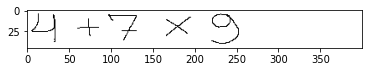

In [73]:
expression = cv2.imread('../expressions/outside-expression-3.png', DATASET_IMAGES_FLAG)
plt.imshow(expression, cmap='gray')

In [74]:
rois = list(get_bbs(expression))

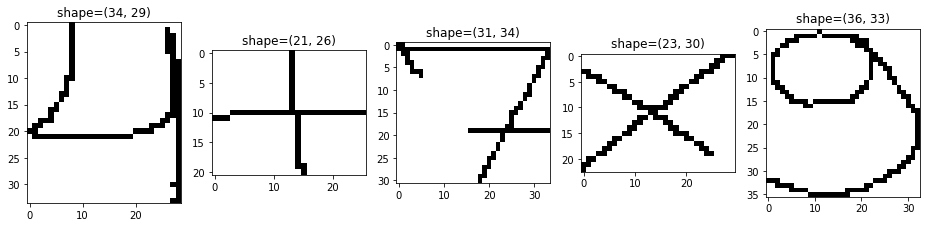

In [77]:
fig, axs = plt.subplots(1, len(rois), figsize=(16, 4))

for i, roi in enumerate(rois):
    axs[i].imshow(roi, cmap='gray')
    axs[i].set_title(f'shape={roi.shape}')

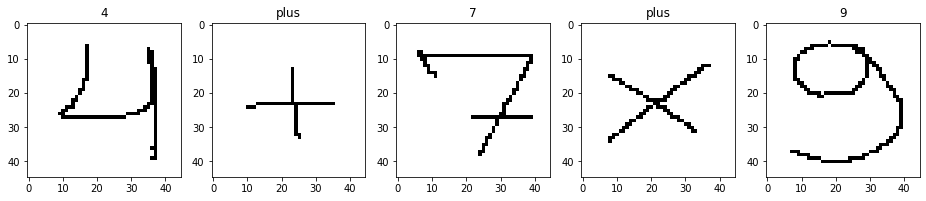

In [64]:
fig, axs = plt.subplots(1, len(rois), figsize=(16, 4))

for i, roi in enumerate(rois):
    padded_image = pad_image(roi)
    prediction = predict(pre_processing(padded_image)[np.newaxis, :, :, np.newaxis])
    
    axs[i].imshow(padded_image, cmap='gray')
    axs[i].set_title(prediction)
    # axs[i].axis('off')